# Disease detection from Chest X-Ray

## Project Goal:

Build a deep learning model that can classify chest X-ray images as either Normal or Pneumonia, helping demonstrate how AI can support medical diagnosis.

📦 Dataset:

Chest X-Ray Images (Pneumonia) - Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia





- 5,863 total images across training, test, and validation folders



- Two classes: NORMAL, PNEUMONIA

In [1]:
import tensorflow as tf
import os

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Load dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
data_dir = "/content/drive/MyDrive/chest_xray"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_gen = train_datagen.flow_from_directory(
    f"{data_dir}/train", target_size=(150,150), class_mode='binary', batch_size=32
)


Found 5244 images belonging to 2 classes.


In [13]:
test_gen = train_datagen.flow_from_directory(
    directory=f"{data_dir}/test",
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
)

Found 624 images belonging to 2 classes.


## Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

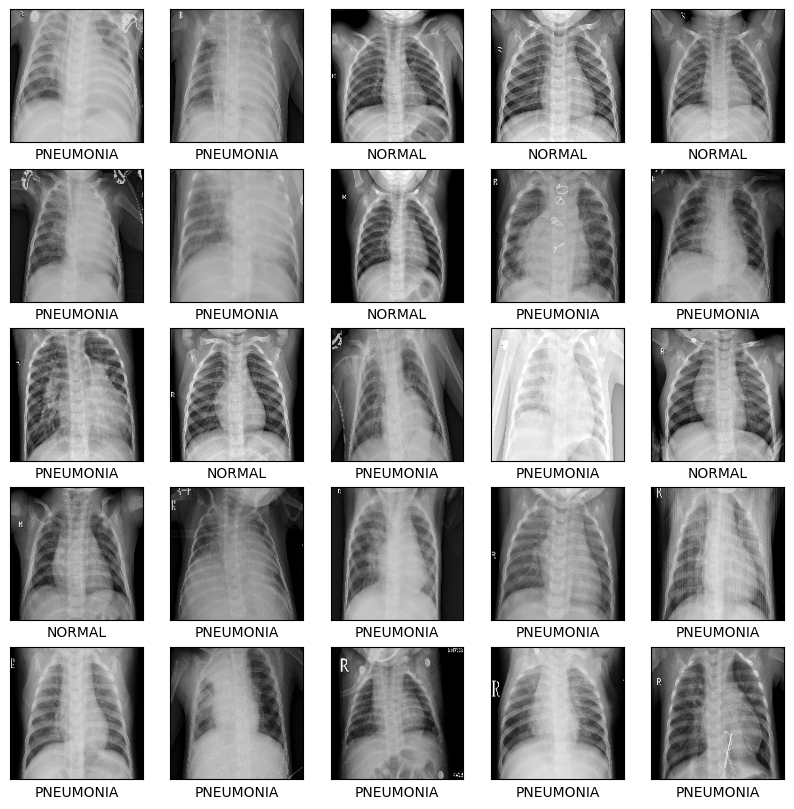

In [14]:

class_names = ['NORMAL', 'PNEUMONIA']

# Get 25 sample images from the training generator
images, labels = next(train_gen)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    label = int(labels[i])
    plt.xlabel(class_names[label])
plt.show()


In [15]:
from collections import Counter
def count_classes(folder):
    normal = len(os.listdir(f"{folder}/NORMAL"))
    pneumonia = len(os.listdir(f"{folder}/PNEUMONIA"))
    return {'NORMAL': normal, 'PNEUMONIA': pneumonia}

print("Train:", count_classes(f"{data_dir}/train"))
print("Test:", count_classes(f"{data_dir}/test"))

Train: {'NORMAL': 1350, 'PNEUMONIA': 3896}
Test: {'NORMAL': 234, 'PNEUMONIA': 390}


## Create the convolutional base

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

Let's display the architecture of your model so far:

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

##  Add Dense layers on top

In [18]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,666 (1.12 MB)

 Trainable params: 294,666 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

## Compile & Train

In [24]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(train_gen, validation_data=test_gen, steps_per_epoch=50, validation_steps=20, epochs=10)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8702 - loss: 0.3533

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 739s 15s/step - accuracy: 0.8704 - loss: 0.3520 - val_accuracy: 0.8013 - val_loss: 0.5000
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.9282 - loss: 0.1890 - val_accuracy: 0.7532 - val_loss: 0.6566
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.9331 - loss: 0.1618 - val_accuracy: 0.7772 - val_loss: 0.5493
Epoch 4/10
14/50 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.9547 - loss: 0.1276

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 690ms/step - accuracy: 0.9504 - loss: 0.1358 - val_accuracy: 0.7740 - val_loss: 0.5779
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9611 - loss: 0.1033 - val_accuracy: 0.7468 - val_loss: 0.9103
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9561 - loss: 0.1080 - val_accuracy: 0.7788 - val_loss: 0.7251
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9572 - loss: 0.1231 - val_accuracy: 0.7324 - val_loss: 0.9068
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - accuracy: 0.9503 - loss: 0.1145 - val_accuracy: 0.7324 - val_loss: 1.0040
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9596 - loss: 0.1103 - val_accuracy: 0.7372 - val_loss: 1.0127
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 862ms/step - accuracy: 0.9731 - loss: 0.0830 - val_accuracy: 0.8333 - val_loss: 0.4617


while training accuracy increases and loss decreases, val_accuracy kept the same interval, and val_loss increased then decreased at the last epoch; no clear overfitting

## Evaluation

Metrics + Confusion Matrix

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step
              precision    recall  f1-score   support

      NORMAL       0.37      0.24      0.29       234
   PNEUMONIA       0.62      0.76      0.69       390

    accuracy                           0.56       624
   macro avg       0.50      0.50      0.49       624
weighted avg       0.53      0.56      0.54       624



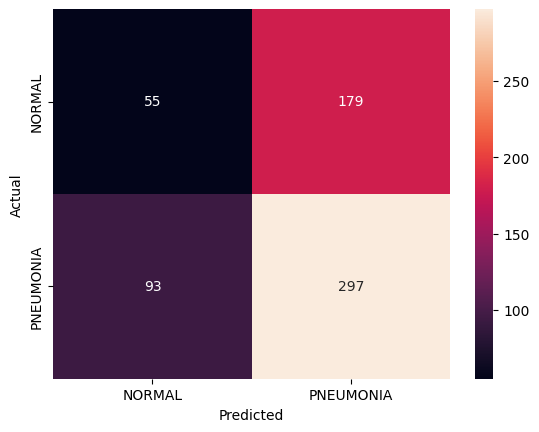

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


The current model achieves moderate performance in detecting pneumonia, with higher recall (76%) but limited precision (62%), while its ability to correctly classify normal cases is poor (24% recall). The overall accuracy of 56% indicates the model requires significant improvement before clinical application. Future work should focus on addressing class imbalance, improving model architecture, and refining decision thresholds to enhance both sensitivity and specificity.

Training Curves

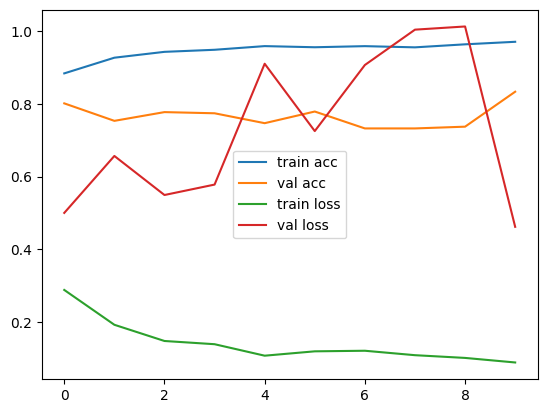

In [29]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## Interpretation & Conclusion

The model shows moderate success in detecting pneumonia cases, with a recall of 75%, meaning it correctly identifies most pneumonia patients. However, its performance in recognizing normal (healthy) cases is poor, with only 22% recall, indicating many healthy cases are misclassified. The overall accuracy of 55% suggests the model’s predictions are only slightly better than random guessing.

These results indicate that the model needs further improvement, especially to better distinguish normal cases and reduce false positives. Typically, this would involve retraining with more data, adjusting model architecture and data imbalances, or tuning thresholds.

Due to limited internet connectivity causing slow training times, I am pausing further retraining at this stage. Future work will focus on addressing these issues to enhance the model’s reliability and clinical usefulness.